Files already downloaded and verified


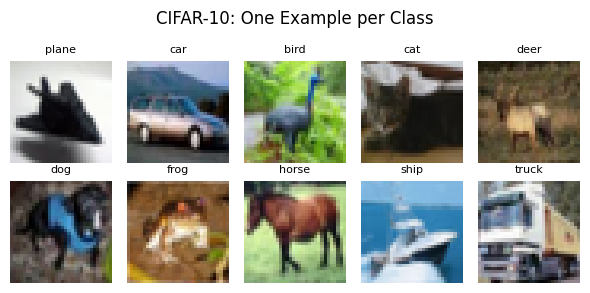

In [2]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 클래스 이름
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 이미지 정규화 및 텐서 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR-10 학습 데이터셋 불러오기
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 클래스별로 예시 이미지 1장씩 수집
class_images = [None] * 10
class_found = [False] * 10

for img, label in train_set:
    if not class_found[label]:
        class_images[label] = img
        class_found[label] = True
    if all(class_found):
        break

# 정규화 해제 후 이미지 출력 함수
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 시각화 출력
plt.figure(figsize=(6, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    imshow(class_images[i])
    plt.title(classes[i], fontsize=8)
    plt.axis('off')
plt.suptitle("CIFAR-10: One Example per Class")
plt.tight_layout()
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 장치 설정 (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),                # 3x32x32 → 3072차원 벡터
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)           # 출력: 10 클래스
        )

    def forward(self, x):
        return self.fc(x)

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 3, 32, 32] → [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 32, 32, 32] → [B, 64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 32, 32] → [B, 64, 16, 16]
            nn.Dropout(0.25)                             # 과적합 방지
        )
        self.fc = nn.Sequential(
            nn.Flatten(),                                # [B, 64, 16, 16] → [B, 16384]
            nn.Linear(64*16*16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)                           # 출력: 10 클래스
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [4]:
from torch.utils.data import DataLoader

# 학습용 데이터 로더
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# 테스트 데이터셋 불러오기
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 테스트용 데이터 로더
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified


In [5]:
def train_and_evaluate(model, name, epochs=10):
    model.to(device)                           # 모델을 CPU 또는 GPU로 이동
    criterion = nn.CrossEntropyLoss()          # 분류 문제용 손실 함수
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # ------------------------
        # (1) 학습 단계
        # ------------------------
        model.train()                          # 학습 모드
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()              # 기울기 초기화
            outputs = model(inputs)            # 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()                    # 역전파
            optimizer.step()                   # 파라미터 업데이트

            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # ------------------------
        # (2) 평가 단계
        # ------------------------
        model.eval()                           # 평가 모드
        correct = 0
        total = 0
        with torch.no_grad():                  # 평가에서는 기울기 계산 불필요
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)  # 가장 큰 값의 인덱스를 예측
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)

        # ------------------------
        # (3) 중간 결과 출력
        # ------------------------
        print(f"[{name}] Epoch {epoch+1} - Loss: {train_losses[-1]:.4f} | Test Acc: {accuracy*100:.2f}%")

    return train_losses, test_accuracies


[MLP] Epoch 1 - Loss: 1.6340 | Test Acc: 46.49%
[MLP] Epoch 2 - Loss: 1.4297 | Test Acc: 50.34%
[MLP] Epoch 3 - Loss: 1.3197 | Test Acc: 51.45%
[MLP] Epoch 4 - Loss: 1.2291 | Test Acc: 52.76%
[MLP] Epoch 5 - Loss: 1.1500 | Test Acc: 52.41%
[MLP] Epoch 6 - Loss: 1.0672 | Test Acc: 54.03%
[MLP] Epoch 7 - Loss: 0.9927 | Test Acc: 53.77%
[MLP] Epoch 8 - Loss: 0.9219 | Test Acc: 53.64%
[MLP] Epoch 9 - Loss: 0.8525 | Test Acc: 52.93%
[MLP] Epoch 10 - Loss: 0.7886 | Test Acc: 53.29%
[CNN] Epoch 1 - Loss: 1.4666 | Test Acc: 60.57%
[CNN] Epoch 2 - Loss: 1.1442 | Test Acc: 66.59%
[CNN] Epoch 3 - Loss: 1.0243 | Test Acc: 67.57%
[CNN] Epoch 4 - Loss: 0.9405 | Test Acc: 69.95%
[CNN] Epoch 5 - Loss: 0.8677 | Test Acc: 70.40%
[CNN] Epoch 6 - Loss: 0.8069 | Test Acc: 70.62%
[CNN] Epoch 7 - Loss: 0.7523 | Test Acc: 70.20%
[CNN] Epoch 8 - Loss: 0.7036 | Test Acc: 69.98%
[CNN] Epoch 9 - Loss: 0.6668 | Test Acc: 70.44%
[CNN] Epoch 10 - Loss: 0.6192 | Test Acc: 70.86%


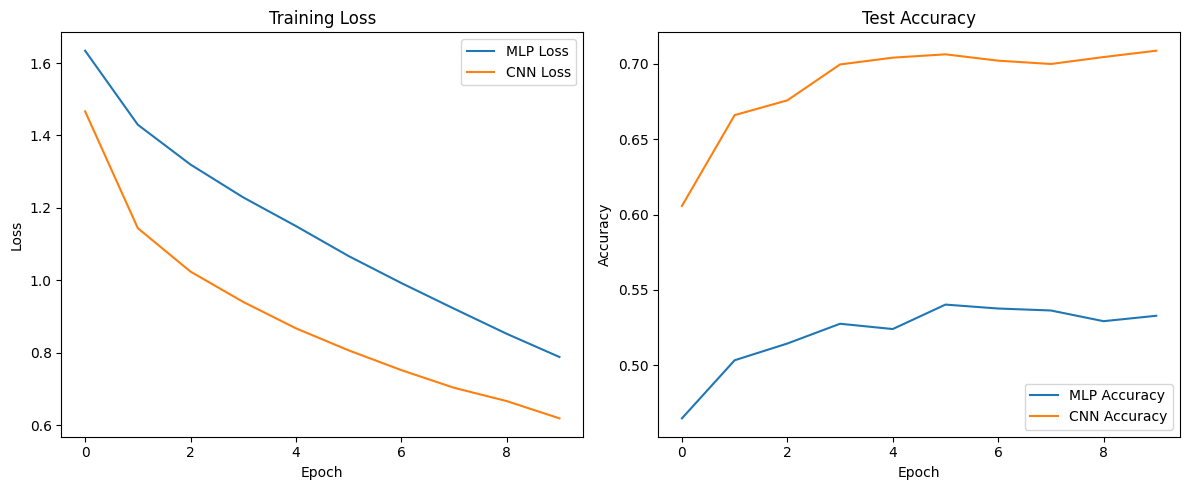

In [6]:
# 모델 생성
mlp_model = MLP()
cnn_model = CNN()

# 모델 학습
mlp_loss, mlp_acc = train_and_evaluate(mlp_model, "MLP", epochs=10)
cnn_loss, cnn_acc = train_and_evaluate(cnn_model, "CNN", epochs=10)

# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# (1) 손실 곡선
plt.subplot(1, 2, 1)
plt.plot(mlp_loss, label='MLP Loss')
plt.plot(cnn_loss, label='CNN Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# (2) 정확도 곡선
plt.subplot(1, 2, 2)
plt.plot(mlp_acc, label='MLP Accuracy')
plt.plot(cnn_acc, label='CNN Accuracy')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
